# Simple Sentiment Analyser

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from nltk.corpus import movie_reviews
from keras.utils import to_categorical
from tqdm import tqdm
import nltk
import spacy

In [2]:
nltk.download('movie_reviews')

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


In [3]:
# Load IMDB Movie Reviews dataset from NLTK
movie_reviews_data = [(movie_reviews.raw(fileid), category) for category in movie_reviews.categories() for fileid in movie_reviews.fileids(category)]

# Extract texts and labels
texts, labels = zip(*movie_reviews_data)

# Convert labels to binary (0 for negative, 1 for positive)
label_to_int = {'neg': 0, 'pos': 1}
labels = [label_to_int[label] for label in labels]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [15]:
# Function to calculate document embeddings using spaCy
def calculate_embeddings(texts):
    embeddings = []
    for text in tqdm(texts):
        doc = nlp(text)
        # Average word vectors to get document vector
        vectors = [token.vector for token in doc if token.has_vector]
        if vectors:
            doc_vector = np.mean(vectors, axis=0)
        embeddings.append(doc_vector)
    return np.array(embeddings)

# Calculate embeddings for training and testing sets
X_train_embeddings = calculate_embeddings(X_train)
X_test_embeddings = calculate_embeddings(X_test)

100%|██████████| 400/400 [00:45<00:00,  8.84it/s]


In [16]:
print(X_train_embeddings.shape, X_test_embeddings.shape)

(1600, 96) (400, 96)


In [18]:
# Build a pipeline with TruncatedSVD and SVM classifier
# Specify the best n_components hyperparameter.
total_accuracies = []
n_components = list(range(5, 97))
for n in n_components:
    accuracies = []

    for i in range(5):
        model = make_pipeline(TruncatedSVD(n_components=n), SVC())

        # Fit the model on training data
        model.fit(X_train_embeddings, y_train)

        # Make predictions on test data
        predictions = model.predict(X_test_embeddings)

        # Evaluate the accuracy
        accuracy = accuracy_score(y_test, predictions)

        accuracies.append(accuracy)
    mean_accuracy = np.mean(accuracies)
    total_accuracies.append(mean_accuracy)
    print(f"{n} Components - Accuracy: {mean_accuracy:.4f}")

5 Components - Accuracy: 0.5850
6 Components - Accuracy: 0.6575
7 Components - Accuracy: 0.6475
8 Components - Accuracy: 0.6550
9 Components - Accuracy: 0.6525
10 Components - Accuracy: 0.6470
11 Components - Accuracy: 0.6485
12 Components - Accuracy: 0.6565
13 Components - Accuracy: 0.6600
14 Components - Accuracy: 0.6500
15 Components - Accuracy: 0.6500
16 Components - Accuracy: 0.6615
17 Components - Accuracy: 0.6525
18 Components - Accuracy: 0.6490
19 Components - Accuracy: 0.6580
20 Components - Accuracy: 0.6600
21 Components - Accuracy: 0.6535
22 Components - Accuracy: 0.6585
23 Components - Accuracy: 0.6625
24 Components - Accuracy: 0.6650
25 Components - Accuracy: 0.6665
26 Components - Accuracy: 0.6675
27 Components - Accuracy: 0.6680
28 Components - Accuracy: 0.6665
29 Components - Accuracy: 0.6745
30 Components - Accuracy: 0.6820
31 Components - Accuracy: 0.6835
32 Components - Accuracy: 0.6815
33 Components - Accuracy: 0.6830
34 Components - Accuracy: 0.6835
35 Components -

In [20]:
print('Max Accuracy:', np.max(total_accuracies))

Max Accuracy: 0.6975


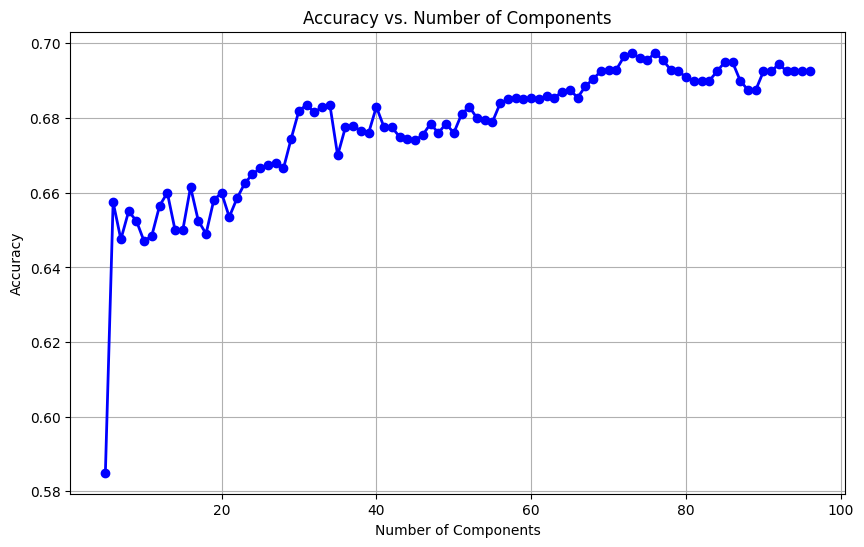

In [24]:
import matplotlib.pyplot as plt

# Plot the total accuracies
plt.figure(figsize=(10, 6))
plt.plot(n_components, total_accuracies, marker='o', color='b', linestyle='-', linewidth=2)

# Add labels and title
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Components')

# Show grid
plt.grid(True)

# Display the plot
plt.show()

#More accurate one

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from nltk.corpus import movie_reviews
from transformers import AutoTokenizer, AutoModel
import torch

In [5]:
# Load BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [6]:
def calculate_embeddings(texts):
    embeddings = []
    for text in tqdm(texts):
        # Tokenize the text
        tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

        # Get BERT model output
        with torch.no_grad():
            model_output = bert_model(**tokens)

        # Use mean pooling to get sentence embeddings
        # Extract the last hidden states of the token embeddings
        token_embeddings = model_output.last_hidden_state
        # Calculate the mean of the token embeddings (No need to apply attention masks, since batch size = 1)
        doc_vector = torch.mean(token_embeddings, dim=1).squeeze()
        embeddings.append(doc_vector)

    return np.array(embeddings)


# Calculate embeddings for training and testing sets
X_train_embeddings = calculate_embeddings(X_train[:1600])
X_test_embeddings = calculate_embeddings(X_test[:400])

100%|██████████| 400/400 [10:09<00:00,  1.52s/it]


In [7]:
print(X_train_embeddings.shape, X_test_embeddings.shape)

(1600, 768) (400, 768)


In [13]:
# Build a pipeline with TruncatedSVD and SVM classifier
# Specify the best n_components hyperparameter.
total_accuracies = []
n_components = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]
for n in n_components:
    accuracies = []

    for i in range(5):
        model = make_pipeline(TruncatedSVD(n_components=n), SVC())

        # Fit the model on training data
        model.fit(X_train_embeddings, y_train)

        # Make predictions on test data
        predictions = model.predict(X_test_embeddings)

        # Evaluate the accuracy
        accuracy = accuracy_score(y_test, predictions)

        accuracies.append(accuracy)
    mean_accuracy = np.mean(accuracies)
    total_accuracies.append(mean_accuracy)
    print(f"{n} Components - Accuracy: {mean_accuracy:.4f}")

5 Components - Accuracy: 0.6565
10 Components - Accuracy: 0.6475
20 Components - Accuracy: 0.6945
30 Components - Accuracy: 0.7695
40 Components - Accuracy: 0.7870
50 Components - Accuracy: 0.7840
60 Components - Accuracy: 0.7860
70 Components - Accuracy: 0.7900
80 Components - Accuracy: 0.7980
90 Components - Accuracy: 0.8020
100 Components - Accuracy: 0.8000
150 Components - Accuracy: 0.7965
200 Components - Accuracy: 0.7930


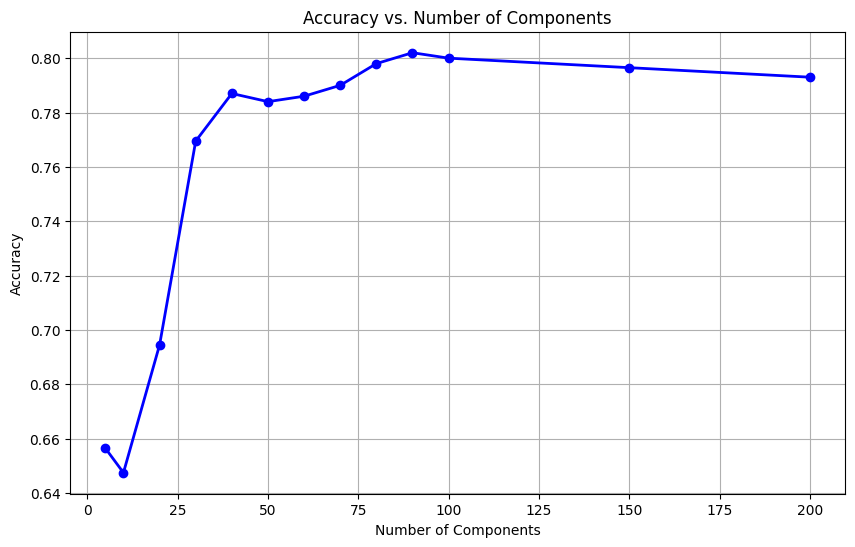

In [14]:
import matplotlib.pyplot as plt

# Create x values for the number of components
n_components = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]

# Plot the total accuracies
plt.figure(figsize=(10, 6))
plt.plot(n_components, total_accuracies, marker='o', color='b', linestyle='-', linewidth=2)

# Add labels and title
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Components')

# Show grid
plt.grid(True)

# Display the plot
plt.show()